In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model  # Importar a função para carregar o modelo
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import warnings
# Suprimir warnings
warnings.filterwarnings("ignore")

In [ ]:
%pip install gdown

In [ ]:
#Baixar modelo treinado
import gdown
gdown.download(f"https://drive.google.com/uc?id=1ZMWrCn4qWHzoOMlCDGXZ5CCirGQMuhUi", "Soja.keras", quiet=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
%pip install split-folders
import splitfolders
#Defina o caminho das suas imagens
input_folder = r"C:\Users\unico\OneDrive\Documentos\ClassificacaoSoja"
#Crie a divisão das imagens em treino (70%), validação (15%) e teste (15%)
splitfolders.ratio(input_folder, output=r"C:\Users\unico\OneDrive\Documentos\SojaDividido",
                    seed=42, ratio=(.7, .15, .15), group_prefix=None)  # group_prefix=None garante a divisão por pasta


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Copying files: 5513 files [00:19, 282.76 files/s] 


In [ ]:

train_path = r'C:\Users\unico\OneDrive\Documentos\SojaDividido\train'
val_path = r'C:\Users\unico\OneDrive\Documentos\SojaDividido\val'
test_path = r'C:\Users\unico\OneDrive\Documentos\SojaDividido\test'

# Augmentação no conjunto de treino
train_batches = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
).flow_from_directory(
    train_path, target_size=(224, 224), shuffle=True, batch_size=32, class_mode='categorical'
)

val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 3856 images belonging to 5 classes.
Found 825 images belonging to 5 classes.
Found 832 images belonging to 5 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Função para bloco residual
def residual_block(x, filters):
    #
    #Define um bloco residual:
    #- Usa duas convoluções 3x3 com Batch Normalization
    #- Adiciona um atalho (skip connection) para melhorar a propagação do gradiente
    #
    shortcut = layers.Conv2D(filters, (1, 1), padding='same')(x)  # Ajusta o número de filtros
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)  # 1ª convolução
    x = layers.BatchNormalization()(x)  # Normalização para estabilidade do treinamento
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)  # 2ª convolução
    x = layers.BatchNormalization()(x)  # Normalização novamente
    x = layers.Add()([x, shortcut])  # Soma da entrada original (atalho) com a saída das convoluções
    x = layers.Activation('relu')(x)  # Ativação após a soma
    return x

# Definição do modelo com blocos residuais
inputs = tf.keras.Input(shape=(224, 224, 3))  # Entrada do modelo com tamanho de imagem 224x224 e 3 canais (RGB)

# Camada inicial de convolução para extração de características básicas
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)  # Primeira camada convolucional
x = layers.BatchNormalization()(x)  # Normalização para estabilizar a rede
x = layers.MaxPooling2D((2, 2))(x)  # Redução da resolução espacial pela metade

# Adicionando blocos residuais para aprendizado mais eficiente
x = residual_block(x, 64)  # 1º bloco residual com 64 filtros
x = layers.MaxPooling2D((2, 2))(x)  # Redução da dimensão da imagem

x = residual_block(x, 128)  # 2º bloco residual com 128 filtros
x = layers.MaxPooling2D((2, 2))(x)

x = residual_block(x, 256)  # 3º bloco residual com 256 filtros
x = layers.MaxPooling2D((2, 2))(x)

# Camadas densas para tomada de decisão
x = layers.Flatten()(x)  # Achata os mapas de características para um vetor
x = layers.Dense(512, activation='relu')(x)  # Camada totalmente conectada com 512 neurônios
x = layers.Dropout(0.4)(x)  # Dropout para evitar overfitting
x = layers.Dense(256, activation='relu')(x)  # Outra camada densa com 256 neurônios
x = layers.Dropout(0.3)(x)  # Outro dropout

outputs = layers.Dense(5, activation='softmax')(x)  # Camada de saída para classificação em 5 categorias

# Criação do modelo
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compilação do modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Otimizador Adam com taxa de aprendizado reduzida
                loss=tf.keras.losses.CategoricalCrossentropy(),  # Função de perda para problemas de classificação multiclasse
                metrics=['acc'])  # Acurácia como métrica de desempenho

# Callbacks para ajustar dinamicamente o treinamento
early_stopping = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)  # Para o treino se a validação não melhorar por 10 épocas
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)  # Reduz a taxa de aprendizado se a perda não melhorar

# Treinamento do modelo
history = model.fit(
    train_batches,  # Dados de treinamento com aumento de dados
    epochs=100,  # Número máximo de épocas
    validation_data=val_batches,  # Dados de validação
    callbacks=[early_stopping, reduce_lr],  # Callbacks para ajuste dinâmico
    batch_size=32  # Tamanho do batch (ajustável conforme a capacidade do hardware)
)


Epoch 1/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - acc: 0.2868 - loss: 3.5173 - val_acc: 0.2036 - val_loss: 1.7943 - learning_rate: 1.0000e-04
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - acc: 0.4322 - loss: 1.3503 - val_acc: 0.2036 - val_loss: 2.5146 - learning_rate: 1.0000e-04
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - acc: 0.4711 - loss: 1.2718 - val_acc: 0.2582 - val_loss: 1.9152 - learning_rate: 1.0000e-04
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - acc: 0.5241 - loss: 1.1906 - val_acc: 0.5200 - val_loss: 1.1582 - learning_rate: 1.0000e-04
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - acc: 0.5834 - loss: 1.0775 - val_acc: 0.5006 - val_loss: 1.2933 - learning_rate: 1.0000e-04
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - acc: 0.6175 - loss: 0.9992 - val_acc: 0.6642 - val_loss: 0.8821 - learning_rate: 1.0000e-04
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - acc: 0.6391 - loss: 0.9355 - val_acc: 0.7212 - val_loss:

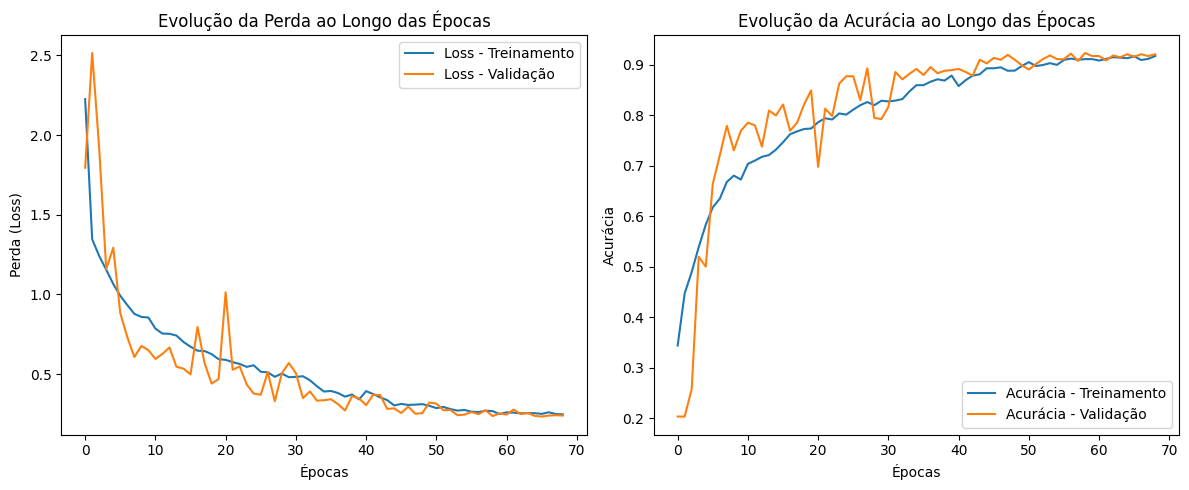

In [15]:
# Plota o gráfico de perda (loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss - Treinamento')
plt.plot(history.history['val_loss'], label='Loss - Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.title('Evolução da Perda ao Longo das Épocas')
plt.legend()

# Plota o gráfico de acurácia (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Acurácia - Treinamento')
plt.plot(history.history['val_acc'], label='Acurácia - Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Evolução da Acurácia ao Longo das Épocas')
plt.legend()

# Mostra os gráficos
plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.utils import plot_model

# Gera a plotagem do modelo e salva como um arquivo de imagem (opcional)
plot_model(model,
           to_file='modelo.png',  # Caminho para salvar a imagem (opcional)
           show_shapes=True,      # Exibe o formato dos tensores nas camadas
           show_layer_names=True, # Exibe os nomes das camadas
           expand_nested=False,   # Expande camadas aninhadas (caso use modelos compostos)
           dpi=96)                # Resolução da imagem


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 112, 112,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 112, 112,  │      2,112 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ add_3[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 56, 56,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 56, 56,    │      8,320 │ max_pooling2d_5[

 Total params: 81,096,529 (309.36 MB)

 Trainable params: 27,031,557 (103.12 MB)

 Non-trainable params: 1,856 (7.25 KB)

 Optimizer params: 54,063,116 (206.23 MB)

In [27]:
model.save('Soja.keras')

In [28]:
loss, acc = model.evaluate(test_batches, verbose=1)
print("Accuracy: ", acc)
print("Loss: ", loss)

832/832 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - acc: 0.9179 - loss: 0.2150
Accuracy:  0.917067289352417
Loss:  0.22935476899147034


Quantidade de filtros: 32
Dimensão de cada filtro: 3x3
Quantidade de canais de entrada: 3
Biases dos filtros (parcial): [-0.00832058 -0.00376937  0.00372216  0.00223442  0.00694342 -0.00564653]


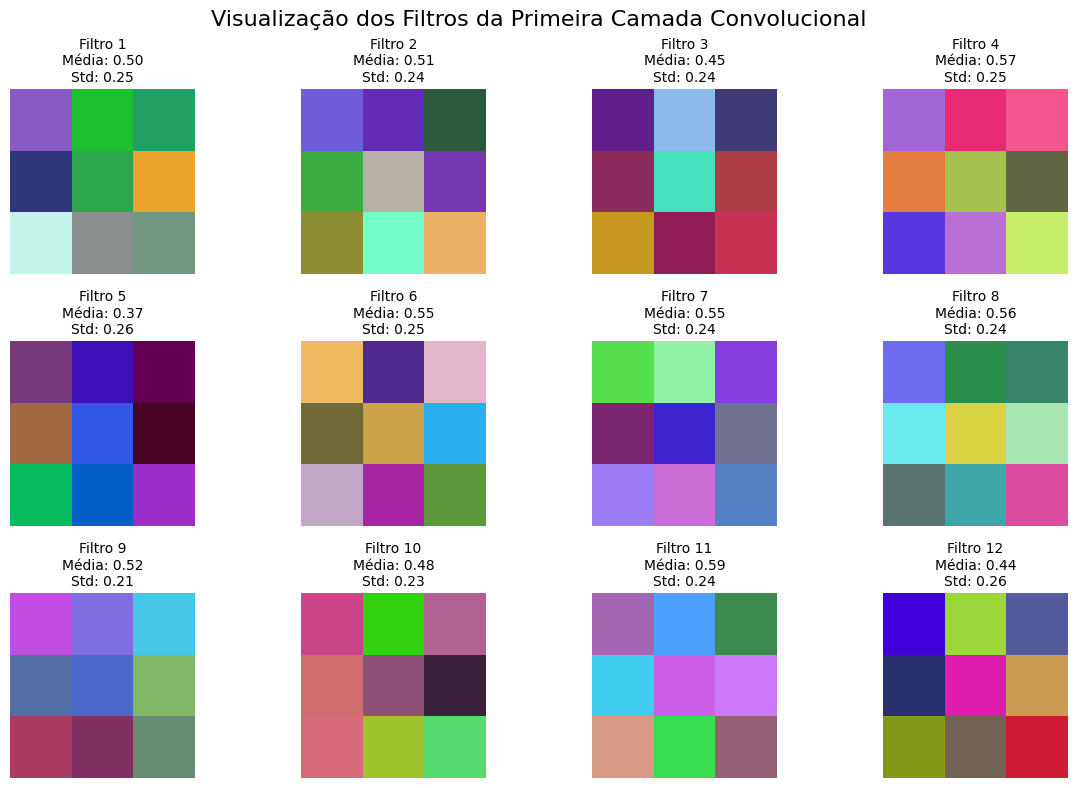

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Extrai os pesos dos filtros e os vieses da primeira camada convolucional
filters, biases = model.layers[1].get_weights()

# Normaliza os filtros para visualização
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Exibe informações adicionais sobre os filtros
print(f"Quantidade de filtros: {filters.shape[-1]}")
print(f"Dimensão de cada filtro: {filters.shape[0]}x{filters.shape[1]}")
print(f"Quantidade de canais de entrada: {filters.shape[2]}")
print(f"Biases dos filtros (parcial): {biases[:6]}")  # Exibe os 6 primeiros vieses

# Define quantos filtros exibir (no máximo)
n_filters = min(12, filters.shape[-1])  # Máximo de 12 filtros
n_cols = 4  # Número de colunas na visualização
n_rows = (n_filters // n_cols) + (1 if n_filters % n_cols != 0 else 0)  # Linhas necessárias

# Plota os filtros com informações adicionais
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
fig.suptitle("Visualização dos Filtros da Primeira Camada Convolucional", fontsize=16)

# Itera sobre cada filtro e exibe suas informações
for i in range(n_filters):
    # Calcula a média e o desvio padrão do filtro
    filtro_media = np.mean(filters[:, :, :, i])
    filtro_std = np.std(filters[:, :, :, i])

    # Localiza o subplot correspondente
    ax = axes[i // n_cols, i % n_cols]
    ax.imshow(filters[:, :, :, i], cmap='viridis')
    ax.axis('off')

    # Adiciona título com informações sobre o filtro
    ax.set_title(f"Filtro {i+1}\nMédia: {filtro_media:.2f}\nStd: {filtro_std:.2f}", fontsize=10)

# Remove eixos vazios, caso existam
for j in range(i + 1, n_cols * n_rows):
    fig.delaxes(axes[j // n_cols, j % n_cols])

# Ajusta layout
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Ajusta o espaço superior para título
plt.show()


In [ ]:
%pip install tf-explain

Found 832 images belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


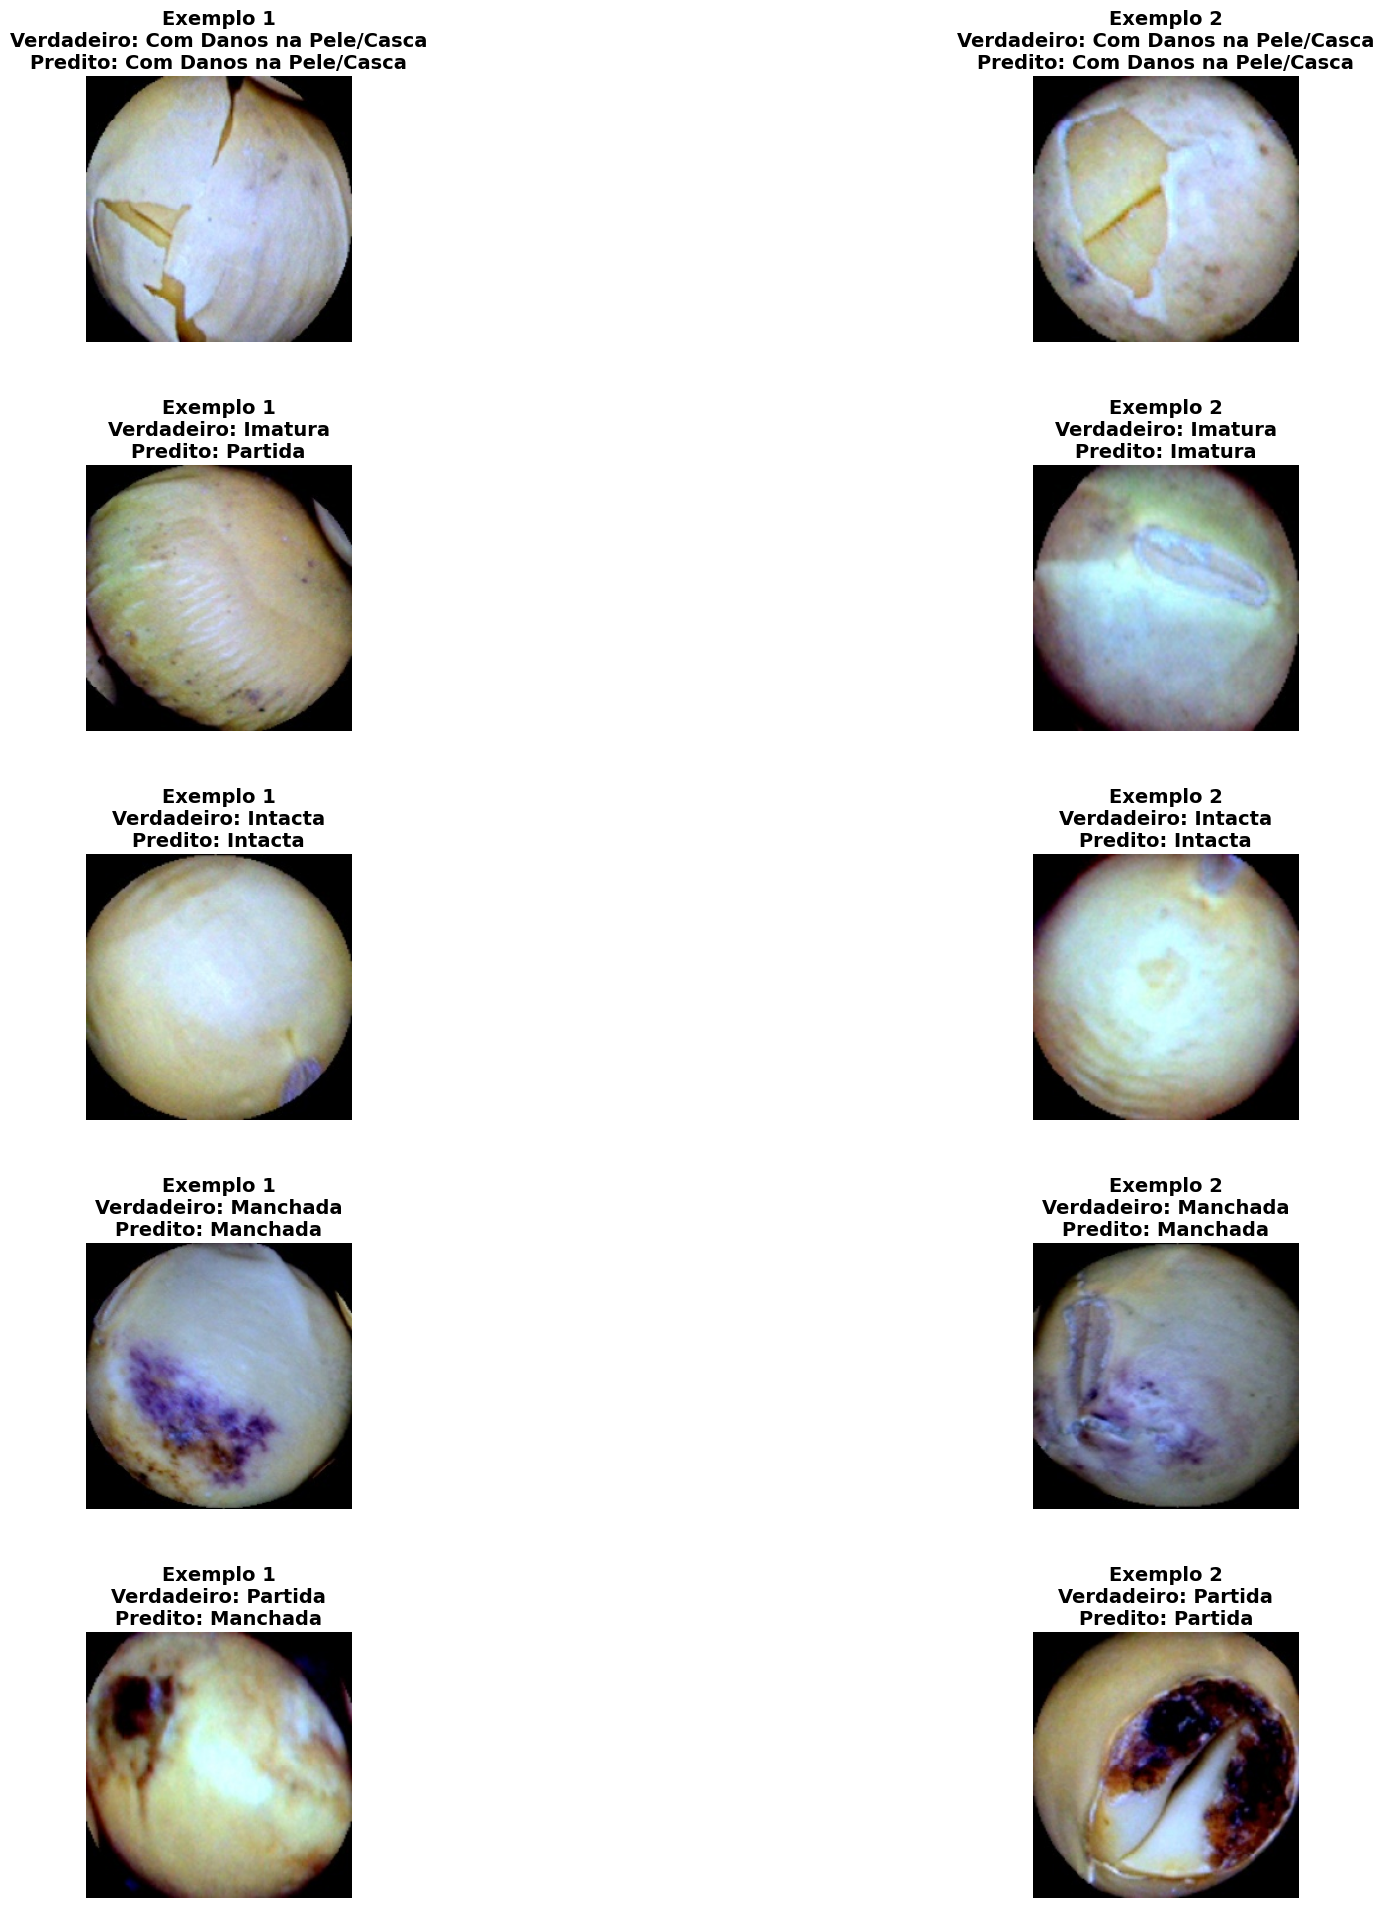

In [41]:
# Função para verificar se um arquivo é uma imagem
def is_image_file(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg'))

# Carrega o modelo salvo
model = load_model('Soja.keras')

# Configura o ImageDataGenerator para carregar as imagens de teste
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=(224, 224),
    shuffle=False,
    batch_size=1,  # Carrega uma imagem por vez
    class_mode='categorical'  # O dataset é de classificação com várias classes
)

# Dicionário para mapear rótulos de classes para índices e vice-versa
class_indices = test_batches.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Dicionário de substituição dos rótulos para a nomenclatura desejada
label_translation = {
    "Partida": "Partida",
    "Imatura": "Imatura",
    "Intacta": "Intacta",
    "Com danos na pele": "Com Danos na Pele/Casca",
    "Manchada": "Manchada"
}

# Seleciona 2 imagens aleatórias de cada classe para visualização
images_per_class = 2
selected_images = []
selected_labels = []

# Caminha pelo diretório de teste para selecionar as imagens
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    if os.path.isdir(class_dir):
        images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if is_image_file(f)]

        # Seleciona aleatoriamente as imagens da classe, se houver mais imagens disponíveis
        if len(images) >= images_per_class:
            selected_images.extend(random.sample(images, images_per_class))
        else:
            selected_images.extend(images)  # Se houver menos imagens, seleciona todas

        selected_labels.extend([class_name] * len(selected_images[-images_per_class:]))  # Adiciona os rótulos correspondentes

# Exibe as imagens com os rótulos verdadeiros e preditivos
plt.figure(figsize=(26, 20))  # Aumenta o tamanho da figura

for i, (img_path, true_label) in enumerate(zip(selected_images, selected_labels)):
    # Carrega e prepara a imagem para a predição
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona dimensão de batch

    # Faz a predição
    prediction = model.predict(img_array)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = index_to_class[predicted_class_idx]

    # Aplica a tradução dos rótulos para a nomenclatura desejada
    true_label_translated = label_translation.get(true_label, true_label)
    predicted_label_translated = label_translation.get(predicted_class, predicted_class)

    # Adiciona espaço entre os subplots
    plt.subplot(len(selected_images) // 2, 2, i + 1)  # Cria subplots com 2 imagens por linha
    plt.imshow(img)

    # Adiciona título com espaço e formatação em negrito
    example_number = i % images_per_class + 1  # Para numerar os exemplos
    plt.title(f'Exemplo {example_number}\nVerdadeiro: {true_label_translated}\nPredito: {predicted_label_translated}', fontsize=14)
    plt.gca().set_title(plt.gca().get_title().replace('Exemplo', r'Exemplo'), fontsize=14, fontweight='bold')
    plt.axis('off')

plt.tight_layout(pad=4)  # Aumenta o espaço entre os subplots
plt.show()

In [42]:
# Defina os caminhos para os dados
model_path = r'C:\Users\unico\Downloads\Soja.keras'  # Caminho para o modelo salvo

# Carregar o modelo
model = load_model(model_path)

# Carregar dados de teste
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=(224, 224),
    shuffle=False,
    class_mode='categorical',  # ou 'binary' dependendo do seu problema
)



# Obter o número total de amostras
total_samples = test_batches.samples

# Ajustar o número de amostras se necessário
num_samples = min(852, total_samples)  # Use o menor valor entre 50 e total_samples

# Obter um lote de amostras do conjunto de teste
X_random_samples = []
y_random_samples = []

for _ in range((total_samples // test_batches.batch_size) + 1):
    try:
        X, y = next(test_batches)
        X_random_samples.extend(X)
        y_random_samples.extend(y)
    except StopIteration:
        break

# Selecionar amostras aleatórias
random_indices = random.sample(range(len(X_random_samples)), num_samples)
X_random_samples = np.array([X_random_samples[i] for i in random_indices])
y_random_samples = np.array([y_random_samples[i] for i in random_indices])

# Fazer previsões
y_random_predictions = model.predict(X_random_samples)

# Como temos um problema de classificação múltipla, precisamos converter os vetores one-hot
y_random_samples_classes = np.argmax(y_random_samples, axis=1)
y_random_predictions_classes = np.argmax(y_random_predictions, axis=1)

# Criar um dicionário para os nomes das classes
class_names = test_batches.class_indices  # Obtém o mapeamento de classes
class_names = {v: k for k, v in class_names.items()}  # Inverte o dicionário

# Criar DataFrame de comparação com nomes das classes traduzidos
comparison_df = pd.DataFrame({
    'Valor Real (y)': [label_translation[class_names[i]] for i in y_random_samples_classes],
    'Predição (ŷ)': [label_translation[class_names[i]] for i in y_random_predictions_classes]
})

print(comparison_df)

Found 832 images belonging to 5 classes.
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 399ms/step
              Valor Real (y)             Predição (ŷ)
0    Com Danos na Pele/Casca  Com Danos na Pele/Casca
1                   Manchada                 Manchada
2                    Imatura                  Imatura
3    Com Danos na Pele/Casca                  Partida
4                    Imatura                  Imatura
..                       ...                      ...
827                  Imatura                  Imatura
828                 Manchada                 Manchada
829  Com Danos na Pele/Casca  Com Danos na Pele/Casca
830                  Intacta                  Intacta
831                  Partida                  Partida

[832 rows x 2 columns]


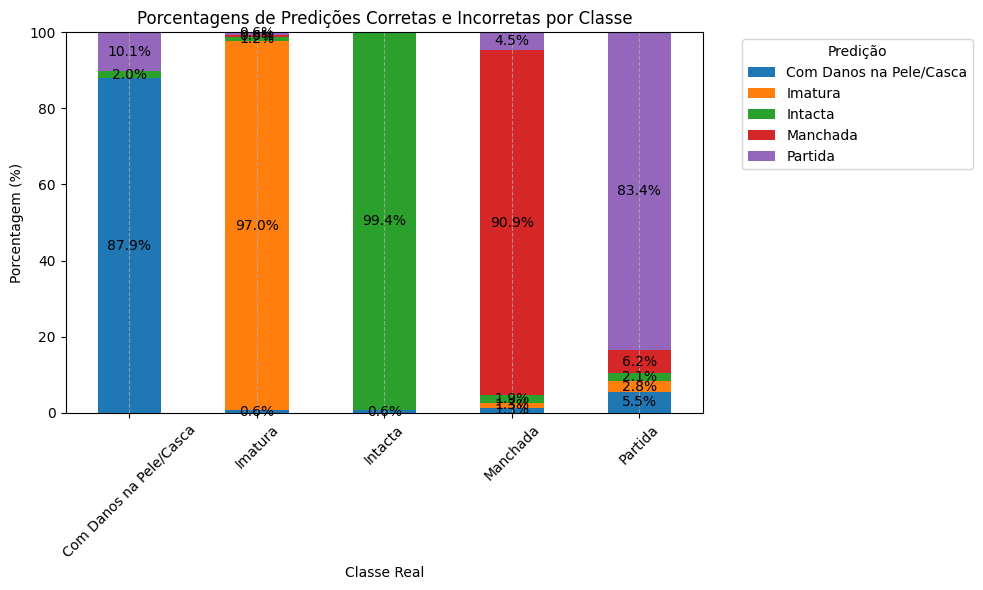

In [44]:
# Calcular as porcentagens de predições corretas e incorretas
results_count = comparison_df.value_counts(['Valor Real (y)', 'Predição (ŷ)']).unstack(fill_value=0)
results_count_percentage = results_count.div(results_count.sum(axis=1), axis=0) * 100

# Criar gráfico de barras para as porcentagens de acertos e erros
fig, ax = plt.subplots(figsize=(10, 6))  # Usando subplots para melhor controle
results_count_percentage.plot(kind='bar', stacked=True, ax=ax)

# Adicionar porcentagens nas barras, excluindo rótulos com valor zero
for container in ax.containers:
    labels = [f'{v:.1f}%' if v > 0 else '' for v in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center')

# Configurações do gráfico
ax.set_title('Porcentagens de Predições Corretas e Incorretas por Classe')
ax.set_xlabel('Classe Real')
ax.set_ylabel('Porcentagem (%)')
ax.legend(title='Predição', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylim(0, 100)  # Limitar o eixo y de 0 a 100%
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Calcular métricas de precisão, recall e F1-Score
precision = precision_score(y_random_samples_classes, y_random_predictions_classes, average='weighted')
recall = recall_score(y_random_samples_classes, y_random_predictions_classes, average='weighted')
f1 = f1_score(y_random_samples_classes, y_random_predictions_classes, average='weighted')

# Exibir os resultados
print(f"Precision (Precisão): {precision:.2f}")
print(f"Recall (Revocação): {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Gerar o relatório de classificação completo
print("\nRelatório de Classificação:\n")
print(classification_report(y_random_samples_classes, y_random_predictions_classes, target_names=[label_translation[class_names[i]] for i in range(len(class_names))]))


Precision (Precisão): 0.92
Recall (Revocação): 0.92
F1-Score: 0.92

Relatório de Classificação:

                         precision    recall  f1-score   support

Com Danos na Pele/Casca       0.93      0.88      0.91       196
                Imatura       0.97      0.98      0.97       163
                Intacta       0.94      0.99      0.97       174
               Manchada       0.93      0.90      0.91       155
                Partida       0.80      0.84      0.82       144

               accuracy                           0.92       832
              macro avg       0.92      0.92      0.92       832
           weighted avg       0.92      0.92      0.92       832

